# Sheet

In [18]:
import numpy as np
import pandas
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

In [19]:
opts_path = "/data/workspace_files/Henry_2010_vols.csv"
opts_prices = pandas.read_csv(opts_path)
opts_prices = opts_prices
#opts_prices["Days_to_Expiry"] = opts_prices["Days_to_Expiry"] - 30 ### coz chatgpt is dumb and didnt account for month ahead expiry for hh options, not needed usually
opts_prices["50D"] = opts_prices["50D"] / 100
opts_prices.head()

,Futures,Contracts,Days_to_Expiry,50D
0,5.41,10-May,60,0.4533
1,5.55,10-Jun,91,0.4262
2,5.72,10-Jul,121,0.4188
3,5.82,10-Aug,152,0.4333
4,5.90,10-Sep,183,0.4546


In [20]:
# Black-Scholes option price (Black model for futures)
def black_model_option_price(F, K, T, r, sigma, option_type='call'):
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif option_type == 'put':
        option_price = np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    return option_price

# N-factor variance calculation
def get_factor_variance(sigma, kappa, T_Fut, T_opt):
    if kappa == 0:
        return sigma**2 * T_opt
    else:
        return sigma**2 * (np.exp(-2 * kappa * (T_Fut - T_opt)) - np.exp(-2 * kappa * T_Fut)) / (2 * kappa)

# N-factor cross-variance calculation (no sqrt required)
def get_cross_factor_variance(sigma1, sigma2, kappa1, kappa2, rho, T_Fut, T_opt):
    cross_variance = sigma1 * sigma2 * rho
    kappa = (kappa1 + kappa2) / 2
    return cross_variance * (np.exp(-2 * kappa * (T_Fut - T_opt)) - np.exp(-2 * kappa * T_Fut)) / (2 * kappa)

# N-factor option price calculation
def get_n_factor_variance(T_Fut, T_opt, sigmas, kappas, correlation_matrix):
    n = len(sigmas)
    total_variance = 0.0

    # Calculate individual factor variances
    for i in range(n):
        total_variance += get_factor_variance(sigmas[i], kappas[i], T_Fut, T_opt)

    # Calculate cross-factor variances
    for i in range(n):
        for j in range(i + 1, n):
            total_variance += 2 * get_cross_factor_variance(sigmas[i], sigmas[j], kappas[i], kappas[j],
                                                            correlation_matrix[i, j], T_Fut, T_opt)

    # Total volatility is the square root of total variance
    total_variance = total_variance / T_opt

    return total_variance

# Helper function to create masks for free and fixed parameters
def create_parameter_masks(fixed_params, n):
    total_params = 2 * n + (n * (n - 1)) // 2
    param_mask = np.zeros(total_params)  # Mask for all parameters (sigmas, kappas, and correlations)
    fixed_values = np.zeros(total_params)  # Array to store fixed values

    for key, value in fixed_params.items():
        if key.startswith('sigma'):
            idx = int(key.split('_')[1]) - 1
            param_mask[idx] = 1
            fixed_values[idx] = value
        elif key.startswith('kappa'):
            idx = n + int(key.split('_')[1]) - 1
            param_mask[idx] = 1
            fixed_values[idx] = value
        elif key.startswith('rho'):
            i, j = map(int, key.split('_')[1:])
            corr_index = 2 * n + (i - 1) * (n - i // 2) + (j - i - 1)
            param_mask[corr_index] = 1
            fixed_values[corr_index] = value
    return param_mask, fixed_values

# Objective function for calibrating to implied volatility
def objective_function_volatility(free_params, market_variance, T_Fut, T_opt, r, n, fixed_params, param_mask):
    params = np.zeros_like(param_mask)
    params[param_mask == 0] = free_params  # Free parameters from optimizer
    params[param_mask == 1] = fixed_params[param_mask == 1]

    # Extract sigmas, kappas, and correlations
    sigmas = params[:n]
    kappas = params[n:2*n]
    correlation_values = params[2*n:]

    # Build the correlation matrix
    correlation_matrix = np.eye(n)
    index = 0
    for i in range(n):
        for j in range(i + 1, n):
            correlation_matrix[i, j] = correlation_values[index]
            correlation_matrix[j, i] = correlation_values[index]
            index += 1

    model_variance = []

    # Calculate model-implied volatilities for all options
    for i in range(len(market_volatilities)):
        model_var = get_n_factor_variance(T_Fut[i], T_opt[i], sigmas, kappas, correlation_matrix)
        model_variance.append(model_var)

    # Squared difference between market and model volatilities
    error = np.sum((np.array(market_variance) - np.array(model_variance)) ** 2)

    return error

# Calibration function to find optimal sigmas, kappas, and correlations directly to volatilities
def calibrate_n_factors_to_volatility(market_volatilities, T_Fut, T_opt, r, n, fixed_params):
    market_variance = [x**2 for x in market_volatilities]

    initial_guess_sigmas = [0.2] * n  # Initial guess for volatilities
    initial_guess_kappas = [0.1] * n  # Initial guess for mean-reversion rates
    initial_guess_correlations = [0.5] * (n * (n - 1) // 2)  # Initial guess for correlations

    initial_guess = initial_guess_sigmas + initial_guess_kappas + initial_guess_correlations

    # Create parameter masks and fixed values
    param_mask, fixed_values = create_parameter_masks(fixed_params, n)

    # Only optimize over free parameters
    free_initial_guess = np.array(initial_guess)[param_mask == 0]

    # Bounds for sigmas, kappas, and correlations
    bounds_sigmas = [(0.01, 1.0)] * n
    bounds_kappas = [(0.01, 10.0)] * n
    bounds_correlations = [(-1, 1)] * (n * (n - 1) // 2)

    bounds = bounds_sigmas + bounds_kappas + bounds_correlations
    free_bounds = np.array(bounds)[param_mask == 0]  # Bounds only for free parameters

    # Minimize the objective function
    result = minimize(objective_function_volatility, free_initial_guess, bounds=free_bounds,
                      args=(market_variance, T_Fut, T_opt, r, n, fixed_values, param_mask))

    # Return the optimized free parameters
    optimized_free_params = result.x
    full_params = np.zeros(len(param_mask))
    full_params[param_mask == 0] = optimized_free_params
    full_params[param_mask == 1] = fixed_values[param_mask == 1]

    optimized_sigmas = full_params[:n]
    optimized_kappas = full_params[n:2*n]
    optimized_correlations = full_params[2*n:]

    return optimized_sigmas, optimized_kappas, optimized_correlations

In [21]:

# Sample data for testing
t = 0  # Current time
times = opts_prices["Days_to_Expiry"].to_numpy()/365  # Future times
implied_vols = opts_prices["50D"].to_numpy()  # Sample implied volatilities

# Example data for calibration
F = times  # Futures prices
K = times  # Strike prices
T_Fut = times  # Futures expiry in years
T_opt = times # Option expiry in years
r = 0.02  # Risk-free rate
market_volatilities = implied_vols  # Market-observed volatilities (example)



# Number of factors (e.g., 3 factors)
n = 1

# Example fixed parameters (e.g., fixing sigma_1 and rho_12)
fixed_params = {
   # "kappa_3": 0
}

# Perform the calibration to volatilities
sigmas_opt, kappas_opt, correlations_opt = calibrate_n_factors_to_volatility(
    market_volatilities, T_Fut, T_opt, r, n, fixed_params
)

# Build the correlation matrix
correlation_matrix = np.eye(n)
index = 0
for i in range(n):
    for j in range(i + 1, n):
        correlation_matrix[i, j] = correlations_opt[index]
        correlation_matrix[j, i] = correlations_opt[index]
        index += 1
# Output the optimized parameters
print(f"Calibrated sigmas: {sigmas_opt}")
print(f"Calibrated kappas: {kappas_opt}")
print(f"Calibrated correlations: {correlations_opt}")

Calibrated sigmas: [0.5]
Calibrated kappas: [0.8]
Calibrated correlations: []


In [22]:
opts_prices["Fitted_vols"] = opts_prices.apply(lambda row: np.sqrt(get_n_factor_variance(row["Days_to_Expiry"]/365, row["Days_to_Expiry"]/365, sigmas_opt, kappas_opt, correlation_matrix )
),axis=1)

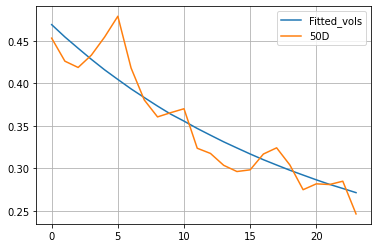

In [23]:
opts_prices[["Fitted_vols", "50D"]].plot()
plt.grid()

In [24]:
def calculate_correct_k(prev_value, j, del_x, alpha, del_t, sig):
    """
    Function to calculate the correct k and associated probabilities for branching in a trinomial tree.

    :param prev_value: The value at the previous time step.
    :param j: The current position in the tree.
    :param del_x: The step size in the price dimension.
    :param alpha: The drift rate.
    :param del_t: The time step size.
    :param sig: Volatility.
    :return: pu (up probability), pd (down probability), k (correct branching level).
    """

    # Calculate the possible branches based on the value of k
    possible_branches = np.abs([del_x + alpha * prev_value * del_t,
                                -alpha * prev_value * del_t,
                                del_x - alpha * prev_value * del_t])

    # Assign indices to possible branches (representing k choices)
    indexed_branches = list(enumerate(possible_branches))

    # Sort the branches by the values (ascending)
    sorted_branches = sorted(indexed_branches, key=lambda x: x[1])

    # Try each sorted k until valid probabilities are found
    for branch in sorted_branches:
        idx, _ = branch  # Extract the index and branch value
        k = idx - 1 + j  # Adjust the k value based on its index

        # Calculate probabilities
        common_term = (k - j) ** 2 + (sig ** 2 * del_t + (alpha * prev_value * del_t) ** 2) / (del_x ** 2)
        pu = 0.5 * (common_term - (k - j) - (1 - 2 * (k - j)) * (alpha * prev_value * del_t) / del_x)
        pd = 0.5 * (common_term + (k - j) + (1 + 2 * (k - j)) * (alpha * prev_value * del_t) / del_x)
        pm = 1 - pu - pd
        # Check if probabilities are valid
        if 0 <= pu <= 1 and 0 <= pd <= 1 and 0 <= pm <= 1:
          return pu, pd, pm, k  # Return valid probabilities and k
    # If no valid probabilities are found, return defaults (this should be rare)
    #return -1, 0.5,0.5, j  # Return a fallback value of pu, pd, and default k

def drift_adjust(Q, x, futures, time_steps,del_t,risk_free):
    """
    Adjust the values in x based on calculated drifts from the provided futures data.

    This function calculates drifts for each time step and adjusts the input array x
    accordingly. It handles non-null values and performs logarithmic calculations.

    Args:
        Q (np.ndarray): Array containing state transitions.
        x (np.ndarray): Initial data array to be adjusted.
        futures (np.ndarray): Future values used for drift calculation.
        time_steps (int): Specific time step for adjusting the first value in x.

    Returns:
        tuple: A list of calculated drifts and the adjusted x array.
    """
    drifts = [np.log(futures[0])]
    x_adj = x.copy()
    x_adj[time_steps, 0] = drifts[0]

    for i in range(1, Q.shape[1]):  # time steps
        non_nulls = np.flatnonzero(~np.isnan(x[:, i]))
        start, end = non_nulls[0], non_nulls[-1] + 1
        x_req = x[start:end, i]
        states_req = Q[start:end, i]

        drift = np.log(futures[i]*np.exp(-i*del_t*risk_free) / np.dot(states_req, np.exp(x_req)))
        x_adj[start:end, i] += drift
        drifts.append(drift)

    return drifts, x_adj

# Function to plot the adjusted tree with connections
def plot_adj_tree_with_edges(adj_tree, edges):
    plt.figure(figsize=(20, 15))

    # Collect x (time) and y (price) coordinates
    x_vals = []
    y_vals = []
    for i in range(num_steps + 1):
        for j in range(2 * num_steps + 1):
            if not np.isnan(adj_tree[j, i]):
                x_vals.append(i)
                y_vals.append(adj_tree[j, i])

    # Plot the nodes (prices at different times)
    plt.scatter(x_vals, y_vals, color="blue", zorder=2, s=10)

    # Plot the edges (connections between nodes)
    for edge in edges:
        start, end = edge
        x_values = [start[0], end[0]]  # Time steps
        y_values = [adj_tree[start[1], start[0]], adj_tree[end[1], end[0]]]  # Prices
        plt.plot(x_values, y_values, color="blue", zorder=1, lw=.5)

    # Set axis labels and title
    plt.xlabel("Time Step", fontsize=14)
    plt.ylabel("Adjusted Price", fontsize=14)
    plt.title("Adjusted Trinomial Tree with Next Node Connections", fontsize=16)
    
    # Show the plot
    #plt.grid(True)
    plt.show()

In [25]:
np.set_printoptions(precision=1)

In [26]:
def construct_tree(num_steps, del_x, alpha, del_t, sig, futures_file, risk_free,verbose = False):
    futures = pandas.read_csv(futures_file)
    futures_req = futures["Futures"].iloc[0:num_steps+1].to_numpy().astype("float")
    
    tree_matrix = np.empty((2*num_steps + 1, num_steps+1))
    state_prices = np.zeros((2*num_steps + 1, num_steps+1))
    tree_matrix.fill(np.nan)
    tree_matrix[num_steps,0] = 0
    state_prices[num_steps,0] = 1
    
    edges = []
    
    ### probability matrices
    prob_matrix = np.empty((2*num_steps + 1, num_steps+1, 3))
    prob_matrix.fill(np.nan)
    
    index_matrix = np.empty((2*num_steps + 1, num_steps+1, 3))
    index_matrix.fill(np.nan)
    
    for i in range(1, num_steps+1):
        prev_step = tree_matrix[:, i - 1]
        prev_prices = state_prices[:, i - 1]
        non_nulls = np.argwhere(~np.isnan(prev_step)).reshape(-1,)
        for j in range(non_nulls[0], non_nulls[-1]+1):
            pu, pd, pm, k = calculate_correct_k(prev_step[j], j, del_x, alpha, del_t, sig)
            prob_matrix[j, i-1] = [pu, pm, pd]
            index_matrix[j, i-1] = [k-1, k, k+1]
            probs_arr = [pu, pm, pd]
            for node in range(k-1, k+2):  # Ensure j is within valid bounds
                tree_matrix[node, i] = prev_step[j] + (node-j)*del_x
                state_prices[node, i] += probs_arr[node-k+1]*prev_prices[j]*np.exp(-risk_free*del_t)  ### cumulate the probability here as that represents state price in fwd measure
                edges.append(((i - 1, j), (i, node)))
    
    state_prices[state_prices == 0] = np.nan
    drifts, adj_tree = drift_adjust(state_prices, tree_matrix, futures_req, num_steps, del_t, risk_free)
    if verbose:
        plot_adj_tree_with_edges(tree_matrix, edges)
        plot_adj_tree_with_edges(np.exp(adj_tree), edges)
    return adj_tree, prob_matrix, index_matrix

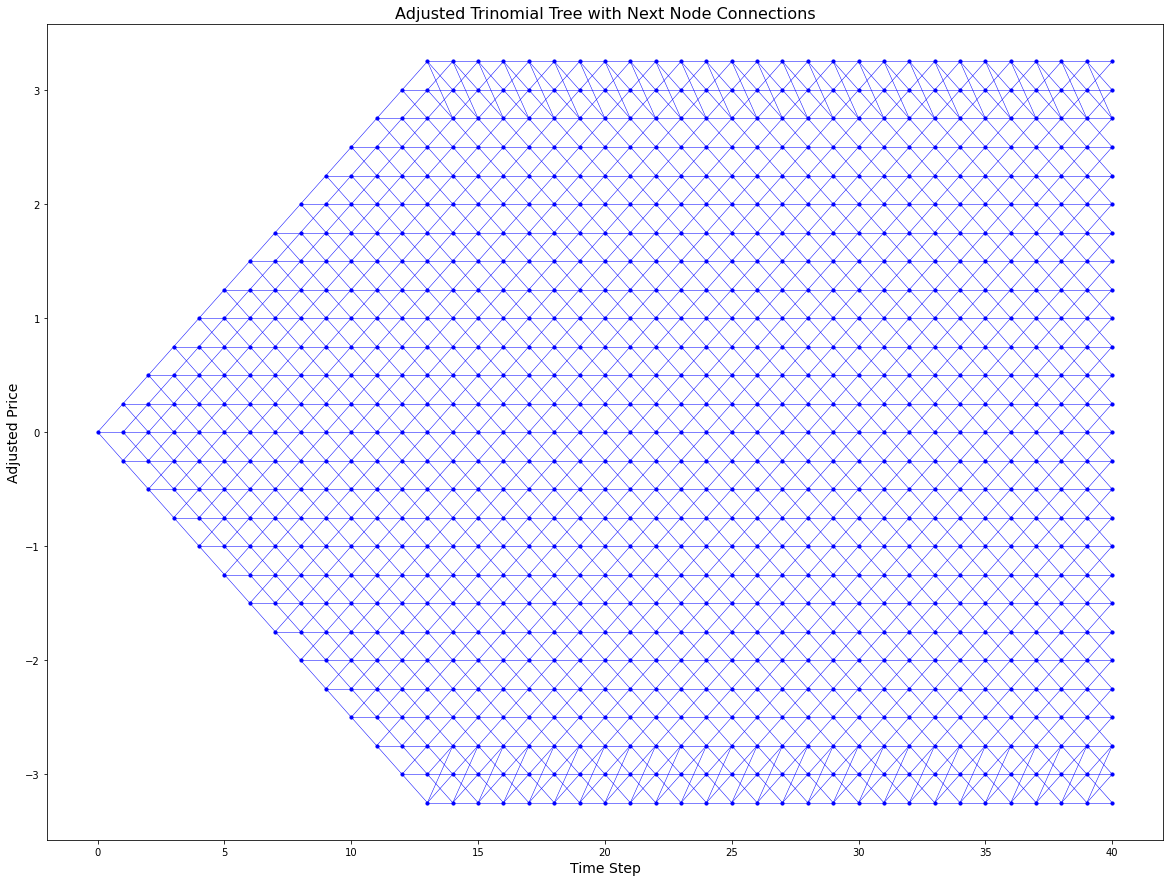

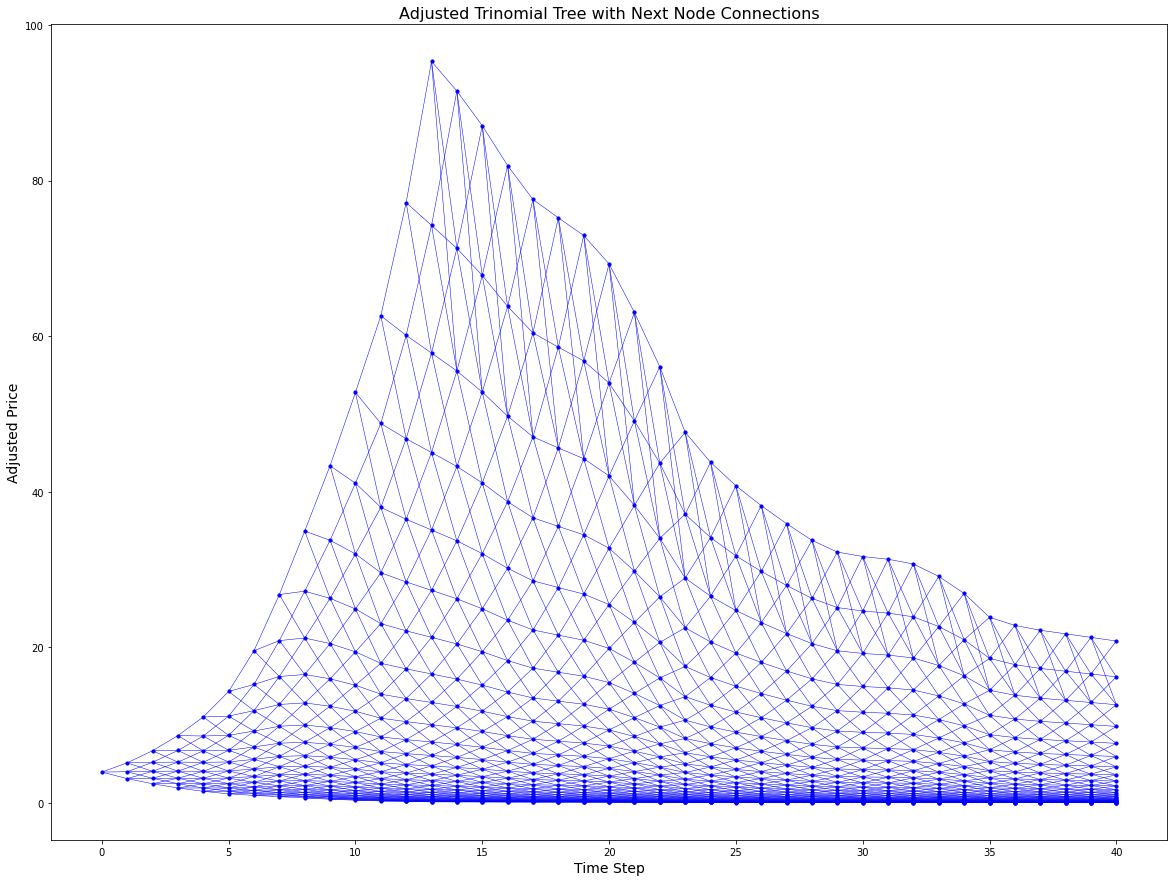

In [27]:
num_steps = 40
futures_file = "/data/workspace_files/Henry_2010_futs.csv"
sig, alpha = sigmas_opt[0], kappas_opt[0]

del_t = 1/12 ### size of time movement
del_x = sig*np.sqrt(3*del_t)
num_steps = 40
risk_free = 0.037
## Call the function
adj_tree, prob_matrix, index_matrix = construct_tree(
    num_steps=num_steps,
    del_x=del_x,
    alpha=alpha,
    del_t=del_t,
    sig=sig,
    futures_file=futures_file,
    risk_free=risk_free,
    verbose = True
)

In [34]:
sig

0.49963259226370904

In [29]:
import math
#### Some initializations for solving the dp of pricing the contract
spot_limits = 2*num_steps + 1
time_limits = num_steps+1
inventory_disc = 50 ### discretization for inventory levels
V_dp = np.zeros((spot_limits,time_limits,inventory_disc + 1))
V_dp[:,-1,:] = -1e12 ### should have no inventory at the end
V_dp[:,-1,0] = 0 ### no penalty if having no inventory

f = 2.5e-2
mdiq_day = 6250
mdwq_day = 6250
inj_cost = 0.015
MSQ = 1e6
num_days = 30
mdiq = mdiq_day*num_days
mdwq = mdwq_day*num_days
withdraw_cost = 0.01
inj_rate = mdiq/MSQ
withdraw_rate = mdwq/MSQ
dz = 1/inventory_disc

### injection interval sizes for dz
dzic = math.ceil(inj_rate/dz)
dzif = math.floor(inj_rate/dz)
dzit = inj_rate/dz
### withdrawal interval sizes for dz
dzwc = math.ceil(withdraw_rate/dz)
dzwf = math.floor(withdraw_rate/dz)
dzwt = withdraw_rate/dz

In [30]:
no_nulls = 0
for i in range(time_limits-2,-1,-1):
  df = np.exp(-risk_free*del_t) ### the discounting factor
  valid_states = np.argwhere(~np.isnan(adj_tree[:,i])).reshape(-1,)
  for j in range(valid_states[0], valid_states[-1]+1):
    probs = prob_matrix[j,i]
    index = index_matrix[j,i].astype(int)
    for z in range(inventory_disc+1):

      ### z represents current volume level
      ### z is usually a fraction and hence we need ceil/floor to interpolate for the value we need in dp

      #### payoff for injecting gas
      zh = min(z+dzic,inventory_disc)
      zl = min(z+dzif,inventory_disc)
      zt = min(z+dzit,inventory_disc)

      high_arr = [V_dp[index[0],i+1,zh], V_dp[index[1],i+1,zh],V_dp[index[2],i+1,zh]]
      low_arr = [V_dp[index[0],i+1,zl], V_dp[index[1],i+1,zl],V_dp[index[2],i+1,zl]]
      val_h = probs.dot(high_arr)
      val_l = probs.dot(low_arr)
      interp_val = val_l + (zt - zl)*(val_h - val_l) ### the interpolated value, no need to divide as the diff of h,l = 1
      inj_qty = (zt-z)*dz*MSQ ### the increment fraction of total volume
      inj_cost_spot = np.exp(adj_tree[j,i]) * inj_qty * (1+f) ### fuel cost of buying gas(spot is from tree)
      inj_cost_comm = inj_cost*inj_qty
      V_inj = interp_val*df - (inj_cost_spot + inj_cost_comm)

      #### payoff for selling gas
      zh = max(z-dzwc,0)
      zl = max(z-dzwf,0)
      zt = max(z-dzwt,0)

      high_arr = [V_dp[index[0],i+1,zh], V_dp[index[1],i+1,zh],V_dp[index[2],i+1,zh]]
      low_arr = [V_dp[index[0],i+1,zl], V_dp[index[1],i+1,zl],V_dp[index[2],i+1,zl]]
      val_h = probs.dot(high_arr)
      val_l = probs.dot(low_arr)
      interp_val = val_l + (zt - zl)*(val_h - val_l) ### the interpolated value, no need to divide as the diff of h,l = 1
      withdrw_qty = (z-zt)*dz*MSQ ### the decrement fraction of total volume
      withdrw_spot_pay = np.exp(adj_tree[j,i]) * withdrw_qty ### withdraw payout
      withdrw_cost_comm = withdraw_cost*withdrw_qty
      V_withdrw = interp_val*df + withdrw_spot_pay - withdrw_cost_comm

      #### payoff for holding inventory
      val_arr = [V_dp[index[0],i+1,z], V_dp[index[1],i+1,z],V_dp[index[2],i+1,z]]
      V_hold = df*probs.dot(val_arr)
      V_dp[j,i,z] = max(V_hold,V_inj,V_withdrw)

In [31]:
# prompt: print dollar amount with comma sep

value = V_dp[40, 0, 0]
formatted_value = "{:,.2f}".format(value)
print(formatted_value)

6,048,864.18


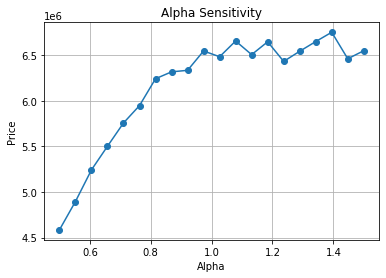

In [35]:
import matplotlib.pyplot as plt
import numpy as np

alpha_values = np.linspace(0.5, 1.5, 20)
price_values = []

for alpha in alpha_values:
    del_t = 1/12  ### size of time movement
    del_x = sig*np.sqrt(3*del_t)
    num_steps = 40
    risk_free = 0.037

    ## Call the function
    adj_tree, prob_matrix, index_matrix = construct_tree(
        num_steps=num_steps,
        del_x=del_x,
        alpha=alpha,
        del_t=del_t,
        sig=sig,
        futures_file=futures_file,
        risk_free=risk_free,
        verbose=False
    )

    no_nulls = 0
    for i in range(time_limits-2, -1, -1):
        df = np.exp(-risk_free*del_t)  ### the discounting factor
        valid_states = np.argwhere(~np.isnan(adj_tree[:, i])).reshape(-1,)
        for j in range(valid_states[0], valid_states[-1]+1):
            probs = prob_matrix[j, i]
            index = index_matrix[j, i].astype(int)
            for z in range(inventory_disc+1):
                ### z represents current volume level
                ### z is usually a fraction, and hence we need ceil/floor to interpolate for the value we need in dp

                #### payoff for injecting gas
                zh = min(z+dzic, inventory_disc)
                zl = min(z+dzif, inventory_disc)
                zt = min(z+dzit, inventory_disc)

                high_arr = [V_dp[index[0], i+1, zh], V_dp[index[1], i+1, zh], V_dp[index[2], i+1, zh]]
                low_arr = [V_dp[index[0], i+1, zl], V_dp[index[1], i+1, zl], V_dp[index[2], i+1, zl]]
                val_h = probs.dot(high_arr)
                val_l = probs.dot(low_arr)
                interp_val = val_l + (zt - zl)*(val_h - val_l)  ### the interpolated value

                inj_qty = (zt-z)*dz*MSQ  ### the increment fraction of total volume
                inj_cost_spot = np.exp(adj_tree[j, i]) * inj_qty * (1+f)  ### fuel cost of buying gas (spot is from tree)
                inj_cost_comm = inj_cost * inj_qty
                V_inj = interp_val * df - (inj_cost_spot + inj_cost_comm)

                #### payoff for selling gas
                zh = max(z-dzwc, 0)
                zl = max(z-dzwf, 0)
                zt = max(z-dzwt, 0)

                high_arr = [V_dp[index[0], i+1, zh], V_dp[index[1], i+1, zh], V_dp[index[2], i+1, zh]]
                low_arr = [V_dp[index[0], i+1, zl], V_dp[index[1], i+1, zl], V_dp[index[2], i+1, zl]]
                val_h = probs.dot(high_arr)
                val_l = probs.dot(low_arr)
                interp_val = val_l + (zt - zl)*(val_h - val_l)  ### the interpolated value

                withdrw_qty = (z-zt)*dz*MSQ  ### the decrement fraction of total volume
                withdrw_spot_pay = np.exp(adj_tree[j, i]) * withdrw_qty  ### withdraw payout
                withdrw_cost_comm = withdraw_cost * withdrw_qty
                V_withdrw = interp_val * df + withdrw_spot_pay - withdrw_cost_comm

                #### payoff for holding inventory
                val_arr = [V_dp[index[0], i+1, z], V_dp[index[1], i+1, z], V_dp[index[2], i+1, z]]
                V_hold = df * probs.dot(val_arr)

                V_dp[j, i, z] = max(V_hold, V_inj, V_withdrw)
    
    price = V_dp[40, 0, 0]
    price_values.append(price)

# Plot alpha sensitivity
plt.plot(alpha_values, price_values, marker='o')
plt.title('Alpha Sensitivity')
plt.xlabel('Alpha')
plt.ylabel('Price')
plt.grid(True)
plt.show()

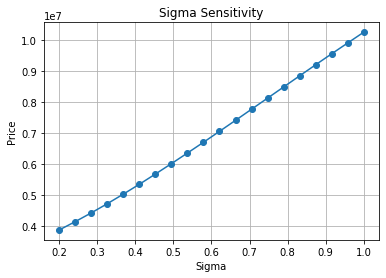

In [37]:
sigma_values = np.linspace(0.2, 1, 20)
price_values2 = []
alpha = kappas_opt[0]

for sig in sigma_values:
    del_t = 1/12  ### size of time movement
    del_x = sig*np.sqrt(3*del_t)
    num_steps = 40
    risk_free = 0.037

    ## Call the function
    adj_tree, prob_matrix, index_matrix = construct_tree(
        num_steps=num_steps,
        del_x=del_x,
        alpha=alpha,
        del_t=del_t,
        sig=sig,
        futures_file=futures_file,
        risk_free=risk_free,
        verbose=False
    )

    no_nulls = 0
    for i in range(time_limits-2, -1, -1):
        df = np.exp(-risk_free*del_t)  ### the discounting factor
        valid_states = np.argwhere(~np.isnan(adj_tree[:, i])).reshape(-1,)
        for j in range(valid_states[0], valid_states[-1]+1):
            probs = prob_matrix[j, i]
            index = index_matrix[j, i].astype(int)
            for z in range(inventory_disc+1):
                ### z represents current volume level
                ### z is usually a fraction, and hence we need ceil/floor to interpolate for the value we need in dp

                #### payoff for injecting gas
                zh = min(z+dzic, inventory_disc)
                zl = min(z+dzif, inventory_disc)
                zt = min(z+dzit, inventory_disc)

                high_arr = [V_dp[index[0], i+1, zh], V_dp[index[1], i+1, zh], V_dp[index[2], i+1, zh]]
                low_arr = [V_dp[index[0], i+1, zl], V_dp[index[1], i+1, zl], V_dp[index[2], i+1, zl]]
                val_h = probs.dot(high_arr)
                val_l = probs.dot(low_arr)
                interp_val = val_l + (zt - zl)*(val_h - val_l)  ### the interpolated value

                inj_qty = (zt-z)*dz*MSQ  ### the increment fraction of total volume
                inj_cost_spot = np.exp(adj_tree[j, i]) * inj_qty * (1+f)  ### fuel cost of buying gas (spot is from tree)
                inj_cost_comm = inj_cost * inj_qty
                V_inj = interp_val * df - (inj_cost_spot + inj_cost_comm)

                #### payoff for selling gas
                zh = max(z-dzwc, 0)
                zl = max(z-dzwf, 0)
                zt = max(z-dzwt, 0)

                high_arr = [V_dp[index[0], i+1, zh], V_dp[index[1], i+1, zh], V_dp[index[2], i+1, zh]]
                low_arr = [V_dp[index[0], i+1, zl], V_dp[index[1], i+1, zl], V_dp[index[2], i+1, zl]]
                val_h = probs.dot(high_arr)
                val_l = probs.dot(low_arr)
                interp_val = val_l + (zt - zl)*(val_h - val_l)  ### the interpolated value

                withdrw_qty = (z-zt)*dz*MSQ  ### the decrement fraction of total volume
                withdrw_spot_pay = np.exp(adj_tree[j, i]) * withdrw_qty  ### withdraw payout
                withdrw_cost_comm = withdraw_cost * withdrw_qty
                V_withdrw = interp_val * df + withdrw_spot_pay - withdrw_cost_comm

                #### payoff for holding inventory
                val_arr = [V_dp[index[0], i+1, z], V_dp[index[1], i+1, z], V_dp[index[2], i+1, z]]
                V_hold = df * probs.dot(val_arr)

                V_dp[j, i, z] = max(V_hold, V_inj, V_withdrw)
    
    price = V_dp[40, 0, 0]
    price_values2.append(price)

# Plot alpha sensitivity
plt.plot(sigma_values, price_values2, marker='o')
plt.title('Sigma Sensitivity')
plt.xlabel('Sigma')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Sheet 2